In [2]:
!git clone https://github.com/shallex/Team12_ML24.git

Cloning into 'Team12_ML24'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 60 (delta 9), reused 47 (delta 6), pack-reused 0
Receiving objects: 100% (60/60), 22.67 MiB | 20.49 MiB/s, done.
Resolving deltas: 100% (9/9), done.


# Code

In [84]:
import json
import os
import torch

import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict
from datetime import datetime
from pathlib import Path

#import seaborn as sns


def show_images(images: list, labels: list[str]=None, n_cols: int=3):
    """
    Show list of images

    Parameters
    ----------
    images : list

    """

    if labels is None:
        labels = [f"pic. {index}" for index in range(1, len(images) + 1)]
    else:
        assert len(images) == len(labels)

    n_rows = len(images) // n_cols + (1 if len(images) % n_cols else 0)

    fig = plt.figure()
    for index, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(n_rows, n_cols, index+1)
        plt.tight_layout()
        plt.imshow(image[0], cmap='gray', interpolation='none')
        plt.title(label)
        plt.xticks([])
        plt.yticks([])

    plt.show();


def split_lists(list_of_tuples: list()) -> tuple():
    """
    List of tuples to tuple of lists.
    """

    assert len(list_of_tuples) > 0

    lists = [[] for index in range(len(list_of_tuples[0]))]
    for element in list_of_tuples:
        for index, subelement in enumerate(element):
            lists[index].append(subelement)

    return tuple(lists)



def get_outputs(model, dataloader, device) -> list():
    """
    Get outputs of the model.
    """

    # Exit training mode.
    was_in_training = model.training
    model.eval()

    outputs = []
    with torch.no_grad():
        for index, batch in enumerate(dataloader):
            x, y = batch

            outputs.append(model(x.to(device)).detach().cpu())

    outputs = torch.cat(outputs)

    # Return to the original mode.
    model.train(was_in_training)

    return outputs


import json
import os
import torch

import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict
from datetime import datetime
from pathlib import Path

#import seaborn as sns


def show_images(images: list, labels: list[str]=None, n_cols: int=3):
    """
    Show list of images

    Parameters
    ----------
    images : list

    """

    if labels is None:
        labels = [f"pic. {index}" for index in range(1, len(images) + 1)]
    else:
        assert len(images) == len(labels)

    n_rows = len(images) // n_cols + (1 if len(images) % n_cols else 0)

    fig = plt.figure()
    for index, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(n_rows, n_cols, index+1)
        plt.tight_layout()
        plt.imshow(image[0], cmap='gray', interpolation='none')
        plt.title(label)
        plt.xticks([])
        plt.yticks([])

    plt.show();


def split_lists(list_of_tuples: list()) -> tuple():
    """
    List of tuples to tuple of lists.
    """

    assert len(list_of_tuples) > 0

    lists = [[] for index in range(len(list_of_tuples[0]))]
    for element in list_of_tuples:
        for index, subelement in enumerate(element):
            lists[index].append(subelement)

    return tuple(lists)



def get_outputs(model, dataloader, device) -> list():
    """
    Get outputs of the model.
    """

    # Exit training mode.
    was_in_training = model.training
    model.eval()

    outputs = []
    with torch.no_grad():
        for index, batch in enumerate(dataloader):
            x, y = batch

            outputs.append(model(x.to(device)).detach().cpu())

    outputs = torch.cat(outputs)

    # Return to the original mode.
    model.train(was_in_training)

    return outputs


import torch
from tqdm import tqdm
from IPython.display import clear_output
import random


class MNIST_ConvEncoder(torch.nn.Module):
    """
    MNIST Convolutional encoder.

    Parameters
    ----------
    latent_dim : int
        Latent representation dimension.
    """

    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        # Noise.
        self.dropout = torch.nn.Dropout(0.1)

        # Activations.
        #self.activation = torch.nn.LeakyReLU()
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        # Convolutions.
        self.conv2d_1 = torch.nn.Conv2d(1, 8, kernel_size=3, padding='same')
        self.conv2d_2 = torch.nn.Conv2d(8, 16, kernel_size=3, padding='same')
        self.conv2d_3 = torch.nn.Conv2d(16, 32, kernel_size=3, padding='same')

        self.maxpool2d = torch.nn.MaxPool2d((2,2))

        # Dense.
        self.linear_1 = torch.nn.Linear(288, 128)
        self.linear_2 = torch.nn.Linear(128, self.latent_dim)


    def forward(self, x: torch.tensor) -> torch.tensor:
        # Convolution №1
        x = self.dropout(x)
        x = self.conv2d_1(x)
        x = self.maxpool2d(x)
        layer_1 = self.activation(x)

        # Convolution №2
        x = self.dropout(layer_1)
        x = self.conv2d_2(x)
        x = self.maxpool2d(x)
        layer_2 = self.activation(x)

        # Convolution №3
        x = self.dropout(layer_2)
        x = self.conv2d_3(x)
        x = self.maxpool2d(x)
        layer_3 = self.activation(x)

        # Dense №1
        x = torch.flatten(layer_3, 1)
        x = self.linear_1(x)
        layer_4 = self.activation(x)

        # Dense №2
        x = self.linear_2(layer_4)
        layer_5 = self.sigmoid(x)

        return layer_5



class MNIST_ConvDecoder(torch.nn.Module):
    """
    MNIST Convolutional decoder.

    Parameters
    ----------
    latent_dim : int
        Latent representation dimension.
    """

    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        # Activations.
        #self.activation = torch.nn.LeakyReLU()
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        # Convolutions.
        self.conv2d_1 = torch.nn.Conv2d(32, 16, kernel_size=3, padding='same')
        self.conv2d_2 = torch.nn.Conv2d(16, 8, kernel_size=3, padding='same')
        self.conv2d_3 = torch.nn.Conv2d(8, 1, kernel_size=3, padding='same')

        self.upsample = torch.nn.Upsample(scale_factor=2)

        # Dense.
        self.linear_1 = torch.nn.Linear(latent_dim, 128)
        self.linear_2 = torch.nn.Linear(128, 1568)


    def forward(self, x: torch.tensor) -> torch.tensor:
        # Dense №1
        x = self.linear_1(x)
        layer_1 = self.activation(x)

        # Dense №2
        x = self.linear_2(layer_1)
        layer_2 = self.activation(x)

        # Convolution №1
        x = torch.reshape(layer_2, (-1, 32, 7, 7))
        x = self.conv2d_1(x)
        x = self.upsample(x)
        layer_3 = self.activation(x)

        # Convolution №2
        x = self.conv2d_2(layer_3)
        x = self.upsample(x)
        layer_4 = self.activation(x)

        # Convolution №3
        x = self.conv2d_3(layer_4)
        layer_5 = x #self.sigmoid(x)

        return layer_5



class CIFAR10_ConvEncoder(torch.nn.Module):
    """
    CIFAR10 Convolutional encoder.

    Parameters
    ----------
    latent_dim : int
        Latent representation dimension.
    """

    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        # Noise.
        self.dropout = torch.nn.Dropout(0.1)

        # Activations.
        #self.activation = torch.nn.LeakyReLU()
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Tanh()

        # Convolutions.
        self.conv2d_1 = torch.nn.Conv2d(3, 16, kernel_size=3, padding='same')
        self.conv2d_2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding='same')
        self.conv2d_3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding='same')

        self.maxpool2d = torch.nn.MaxPool2d((2,2))

        # Dense.
        self.linear_1 = torch.nn.Linear(64*4*4, 128)
        self.linear_2 = torch.nn.Linear(128, self.latent_dim)


    def forward(self, x: torch.tensor) -> torch.tensor:
        # Convolution №1
        x = self.dropout(x)
        x = self.conv2d_1(x)
        x = self.maxpool2d(x)
        layer_1 = self.activation(x)

        # Convolution №2
        x = self.dropout(layer_1)
        x = self.conv2d_2(x)
        x = self.maxpool2d(x)
        layer_2 = self.activation(x)

        # Convolution №3
        x = self.dropout(layer_2)
        x = self.conv2d_3(x)
        x = self.maxpool2d(x)
        layer_3 = self.activation(x)

        # Dense №1
        x = torch.flatten(layer_3, 1)
        x = self.linear_1(x)
        layer_4 = self.activation(x)

        # Dense №2
        x = self.linear_2(layer_4)
        layer_5 = self.sigmoid(x)

        return layer_5



class CIFAR10_ConvDecoder(torch.nn.Module):
    """
    CIFAR10 Convolutional decoder.

    Parameters
    ----------
    latent_dim : int
        Latent representation dimension.
    """

    def __init__(self, latent_dim: int):
        super().__init__()
        self.latent_dim = latent_dim

        # Activations.
        #self.activation = torch.nn.LeakyReLU()
        self.activation = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

        # Convolutions.
        self.conv2d_1 = torch.nn.Conv2d(64, 32, kernel_size=3, padding='same', padding_mode='reflect')
        self.conv2d_2 = torch.nn.Conv2d(32, 32, kernel_size=3, padding='same', padding_mode='reflect')
        self.conv2d_3 = torch.nn.Conv2d(32, 16, kernel_size=3, padding='same', padding_mode='reflect')
        self.conv2d_4 = torch.nn.Conv2d(16, 3, kernel_size=3, padding='same', padding_mode='reflect')

        self.upsample = torch.nn.Upsample(scale_factor=2)

        # Dense.
        self.linear_1 = torch.nn.Linear(latent_dim, 128)
        self.linear_2 = torch.nn.Linear(128, 64*4*4)


    def forward(self, x: torch.tensor) -> torch.tensor:
        # Dense №1
        x = self.linear_1(x)
        layer_1 = self.activation(x)

        # Dense №2
        x = self.linear_2(layer_1)
        layer_2 = self.activation(x)

        # Convolution №1
        x = torch.reshape(layer_2, (-1, 64, 4, 4))
        x = self.conv2d_1(x)
        x = self.upsample(x)
        layer_3 = self.activation(x)

        # Convolution №2
        x = self.conv2d_2(layer_3)
        x = self.upsample(x)
        layer_4 = self.activation(x)

        # Convolution №3
        x = self.conv2d_3(layer_4)
        x = self.upsample(x)
        layer_5 = self.activation(x)

        # Convolution №4
        x = self.conv2d_4(layer_5)
        layer_6 = x

        return layer_6


class Autoencoder(torch.nn.Module):
    """
    Autoencoder.

    Parameters
    ----------
    encoder : torch.nn.Module
        Encoder.
    decoder : torch.nn.Module
        Decoder.
    latent_dim : int
        Latent representation dimension.
    sigma : float
        Standard deviation of additive Gaussian noise,
        injected into the latent representation.
    """

    def __init__(self, encoder, decoder, sigma: float=0.1):
        super().__init__()

        # Encoder and decoder.
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x: torch.tensor) -> torch.tensor:
        latent = self.encoder(x)

        return self.decoder(latent)


    def encode(self, x: torch.tensor) -> torch.tensor:
        return self.encoder(x)


    def decode(self, x: torch.tensor) -> torch.tensor:
        return self.decoder(x)


def evaluate_model(model, dataloader, loss, device, autoencoder_metrics) -> float:
    # Exit training mode.
    was_in_training = model.training
    model.eval()

    with torch.no_grad():
        avg_loss = 0.0
        total_samples = 0
        for batch in dataloader:
            global_idx, x, y = batch
            batch_size = x.shape[0]

            y_pred = model(x.to(device))
            _loss = loss(y_pred, y.to(device))

            avg_loss += _loss.item() * batch_size
            total_samples += batch_size

        avg_loss /= total_samples

    # Return to the original mode.
    model.train(was_in_training)

    return avg_loss, autoencoder_metrics



def train_autoencoder(
    autoencoder,
    train_dataloader,
    test_dataloader,
    autoencoder_loss,
    autoencoder_opt,
    device,
    n_epochs: int=10,
    callback: callable=None, ) -> dict():


    autoencoder_metrics = {
        "train_loss" : [],
        "test_loss" : [],
        "samples_losses": {}
    }

    for epoch in range(1, n_epochs + 1):
        print(f"Epoch №{epoch}")

        sum_loss = 0.0
        total_samples = 0
        for index, batch in tqdm(enumerate(train_dataloader)):
            global_idx, x, y = batch
            batch_size = x.shape[0]

            autoencoder_opt.zero_grad()
            y_pred = autoencoder(x.to(device))
            _loss = autoencoder_loss(y_pred, y.to(device))
            _loss.backward()
            autoencoder_opt.step()

            sum_loss += _loss.item() * len(batch)
            total_samples += len(batch)


        with torch.no_grad():
          for index, batch in tqdm(enumerate(train_dataloader)):
            global_idx, x, y = batch
            y_pred = autoencoder(x.to(device))
            _loss = autoencoder_loss(y_pred, y.to(device))

            for g_idx in global_idx:
                  g_idx = g_idx.item()
                  if autoencoder_metrics["samples_losses"].get(g_idx):
                    autoencoder_metrics["samples_losses"][g_idx].append(_loss.item())
                  else:
                    autoencoder_metrics["samples_losses"][g_idx] = [_loss.item()]


        autoencoder_metrics["train_loss"].append(sum_loss / total_samples)

        #train_loss = evaluate_model(autoencoder, train_dataloader, autoencoder_loss, device)
        #autoencoder_metrics["train_loss"].append(train_loss)
        test_loss, autoencoder_metrics = evaluate_model(autoencoder, test_dataloader, autoencoder_loss, device, autoencoder_metrics)
        autoencoder_metrics["test_loss"].append(test_loss)

        if not (callback is None):
            callback(autoencoder, autoencoder_metrics)

    return autoencoder_metrics

import torch

class AutoencoderDataset(torch.utils.data.Dataset):
    """
    Construct dataset for autoencoder training from another dataset.
    """

    def __init__(self, dataset, train: bool, dim: int=0):
        """
        Initialization.

        Parameters
        ----------
        dataset
            The dataset from which to make dataset for the autoencoder.
        dim : int, optional
            The number of the subelement (in each entry) to be repeated.
        """

        self.dataset = dataset
        self.dim = dim
        self.train = train

        k = 1000

        self.mixed_subdataset = {}

        if train:
          self.rand_samples_idx = random.sample(range(len(self.dataset)), k=k)
          for i in range(k):
            next_i = (i + 1) % k
            mixed_img = (self.dataset[self.rand_samples_idx[i]][0] + self.dataset[self.rand_samples_idx[next_i]][0]) / 2
            self.mixed_subdataset[self.rand_samples_idx[i]] = mixed_img

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if self.train and index in self.rand_samples_idx:
          return (index, self.mixed_subdataset[index], self.mixed_subdataset[index])
        x = self.dataset[index][self.dim]
        return (index, x, x)

# Code 2

In [85]:
import torch
import torchvision
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
from collections import defaultdict
from datetime import datetime
from pathlib import Path
from IPython.display import clear_output

from torchvision.datasets import MNIST

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")

path = Path("../../data/").resolve()
experiments_path = path / "/MNIST/"
models_path = experiments_path / "models/"
# results_path = experiments_path / "resuts/"

# seeding
SEED = 12
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)

Device: cuda
Devices count: 1


In [86]:
"""
Training parameters
"""
# Autoencoder
X_latent_dim = 10             # Input dimension after compression.
X_autoencoder_n_epochs = 100  # Number of epochs to train the autoencoder.
X_autoencoder = Autoencoder(
    MNIST_ConvEncoder(latent_dim=X_latent_dim),
    MNIST_ConvDecoder(latent_dim=X_latent_dim) ).to(device)

# Data
autoencoder_batch_size_train = 512
autoencoder_batch_size_test  = 1024

# Training
autoencoder_loss = torch.nn.L1Loss()
lr = 1e-3
autoencoder_opt = torch.optim.Adam(X_autoencoder.parameters(), lr=lr)

In [87]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

In [88]:
train_dataset = MNIST(root="./.cache", download=True, transform=image_transform)
test_dataset = MNIST(root="./.cache", download=True, transform=image_transform, train=False)

In [89]:
train_dataset_autoencoder = AutoencoderDataset(train_dataset, train=True)
test_dataset_autoencoder = AutoencoderDataset(test_dataset, train=False)

train_dataloader_autoencoder = torch.utils.data.DataLoader(
    train_dataset_autoencoder,
    batch_size=autoencoder_batch_size_train,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
)
test_dataloader_autoencoder  = torch.utils.data.DataLoader(
    test_dataset_autoencoder,
    batch_size=autoencoder_batch_size_test,
    shuffle=False,
    pin_memory=True,
    num_workers=4,
)

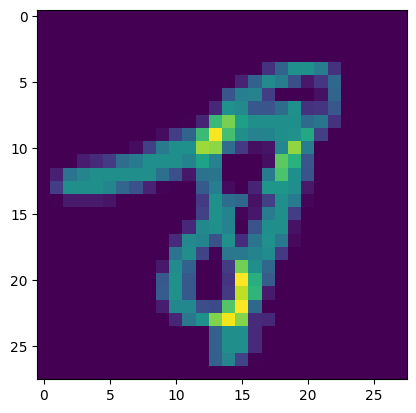

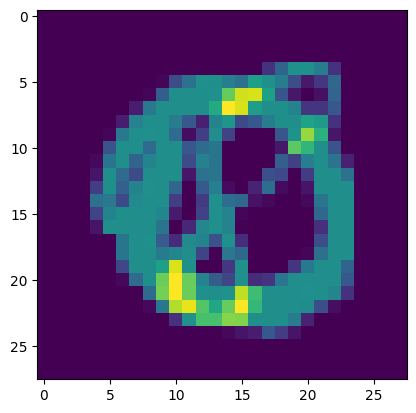

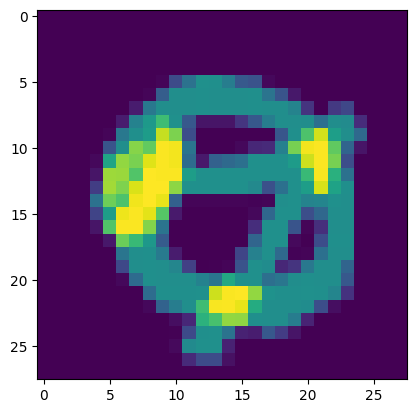

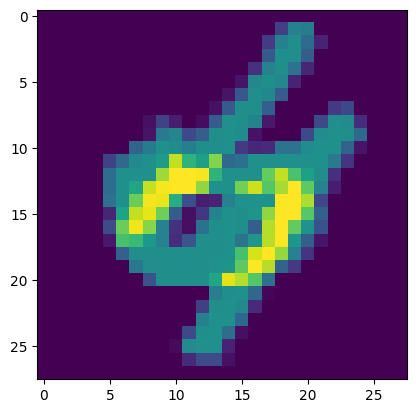

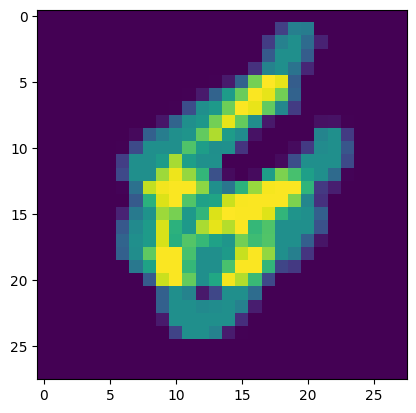

In [93]:
for idx in train_dataset_autoencoder.rand_samples_idx[:5]:
  plt.imshow(train_dataset_autoencoder.mixed_subdataset[idx].squeeze(0))
  plt.show()

In [90]:
def autoencoder_callback(autoencoder, autoencoder_metrics=None):
    clear_output(True)

    was_in_training = autoencoder.training
    autoencoder.eval()

    # Display some images..
    with torch.no_grad():
        samples = [sample[1] for sample in random.choices(test_dataset_autoencoder, k=3)]
        samples += [autoencoder(sample[None,:].to(device)).cpu().detach()[0] for sample in samples]
        show_images(samples)

    # Display loss/metrics plots.
    if not (autoencoder_metrics is None):
        plt.figure(figsize=(12,4))
        for index, (name, history) in enumerate(sorted(autoencoder_metrics.items())):
            if name == "samples_losses":
              continue
            plt.subplot(1, len(autoencoder_metrics), index + 1)
            plt.title(name)
            plt.plot(range(1, len(history) + 1), history)
            plt.grid()

        plt.show();

    autoencoder.train(was_in_training)

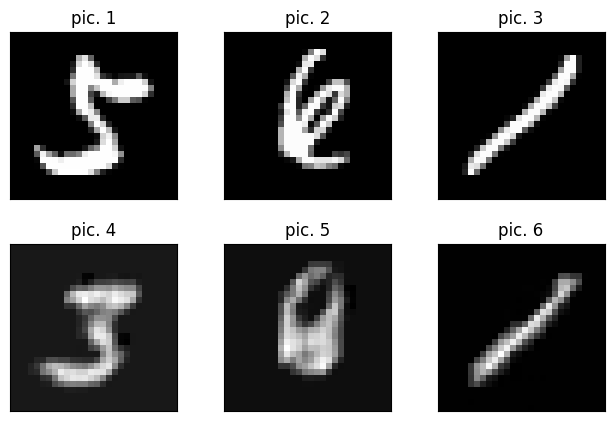

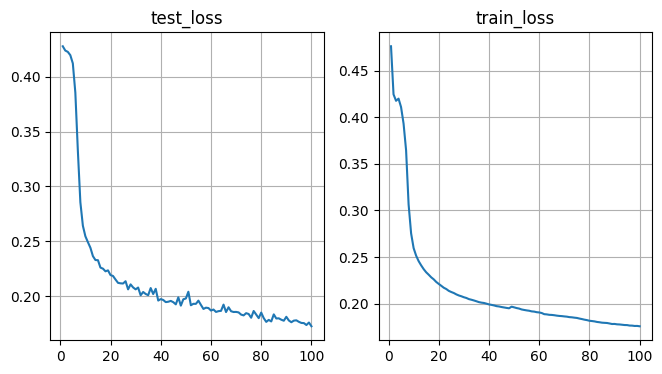

In [91]:
results = train_autoencoder(
    X_autoencoder,
    train_dataloader_autoencoder,
    test_dataloader_autoencoder,
    autoencoder_loss=autoencoder_loss,
    autoencoder_opt=autoencoder_opt,
    n_epochs=X_autoencoder_n_epochs,
    callback=autoencoder_callback,
    device=device,
)

In [ ]:
samples_losses = results["samples_losses"]
samples_losses

In [ ]:
global_indexes = samples_losses.keys()
global_indexes

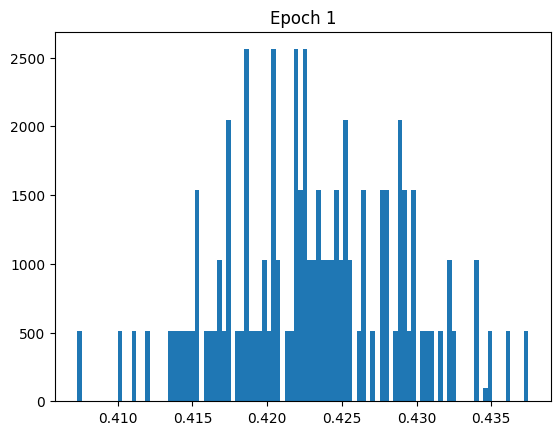

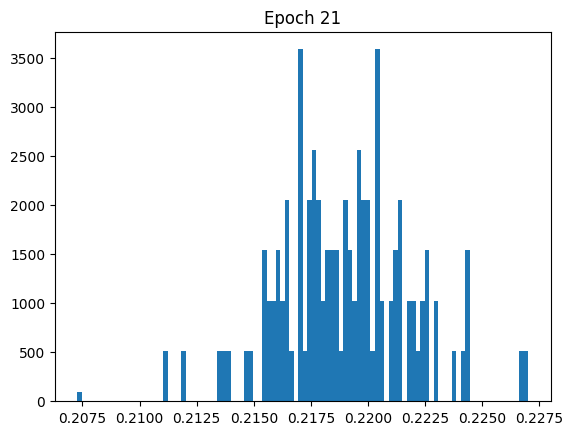

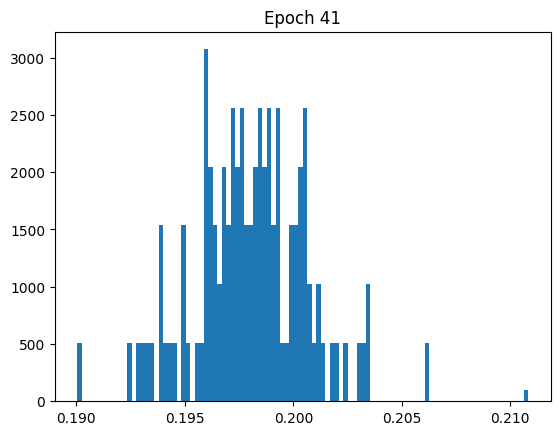

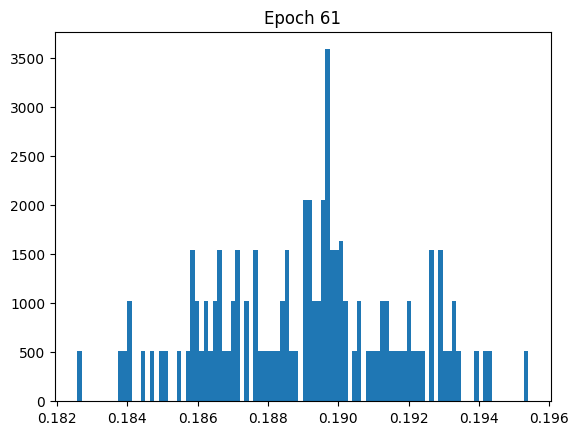

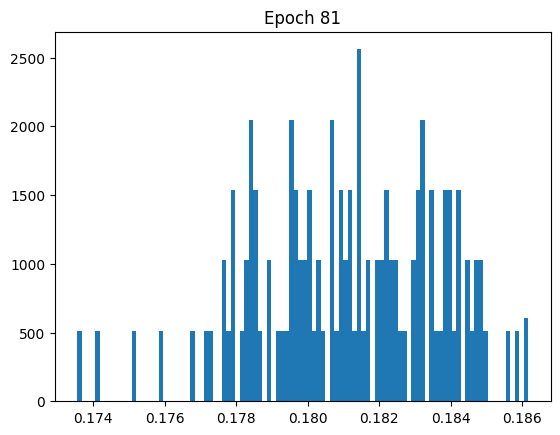

In [97]:

for epoch in range(0, X_autoencoder_n_epochs, 20):
  losses = []
  for g_idx in global_indexes:
    losses.append(samples_losses[g_idx][epoch])

  plt.hist(losses, bins=100)
  plt.title(f"Epoch {epoch + 1}")
  plt.show()

In [131]:
idx_2_sum_loss = {idx: 0 for idx in global_indexes}

start_from = 85

for g_idx in global_indexes:
  for epoch in range(start_from, X_autoencoder_n_epochs):
    idx_2_sum_loss[g_idx] += samples_losses[g_idx][epoch]


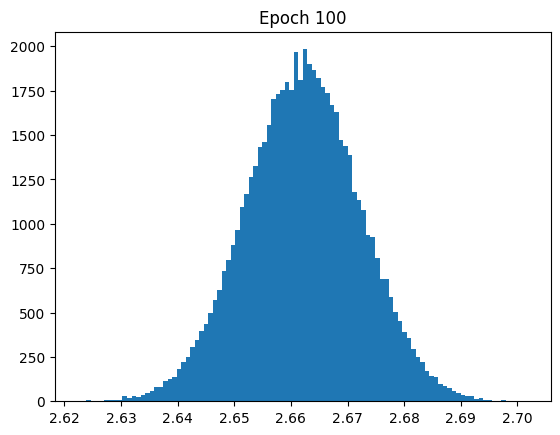

In [132]:
sum_losses = idx_2_sum_loss.values()
plt.hist(sum_losses, bins=100)
plt.title(f"Epoch {epoch + 1}")
plt.show()


In [133]:
q = np.quantile(np.array(list(sum_losses)), q=0.999)
q

2.6931581680476664

In [134]:
sum(np.array(list(sum_losses)) > q)

60

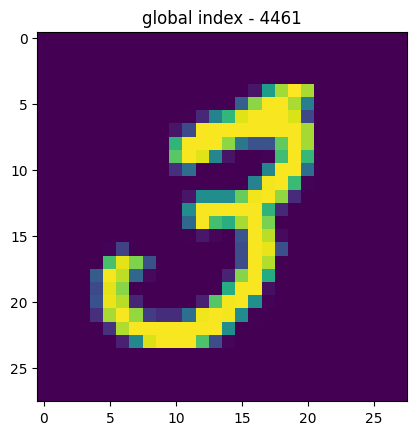

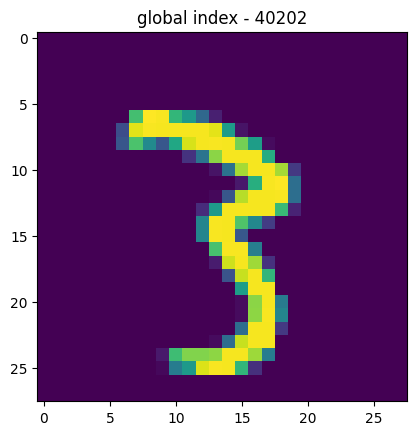

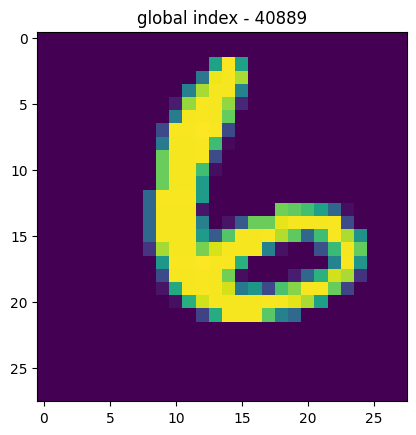

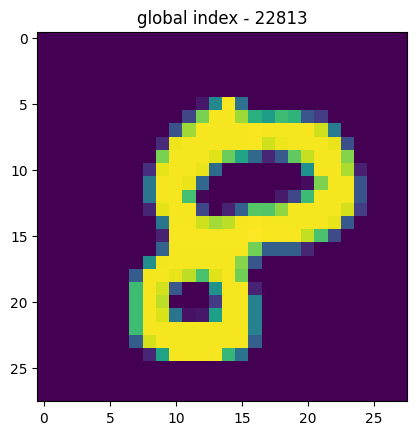

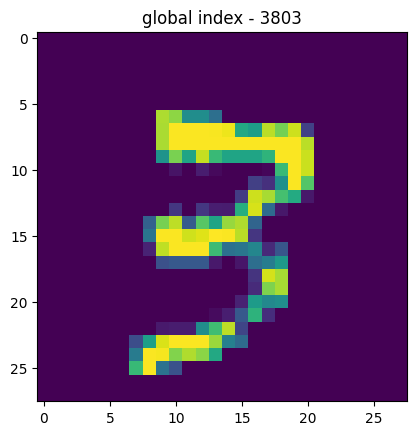

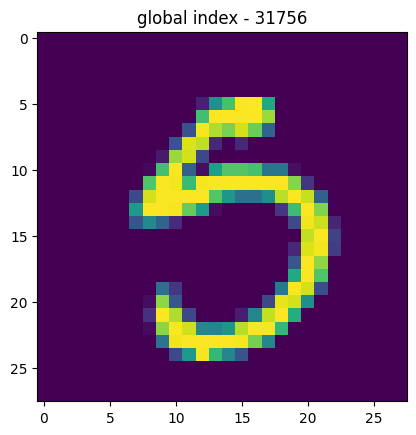

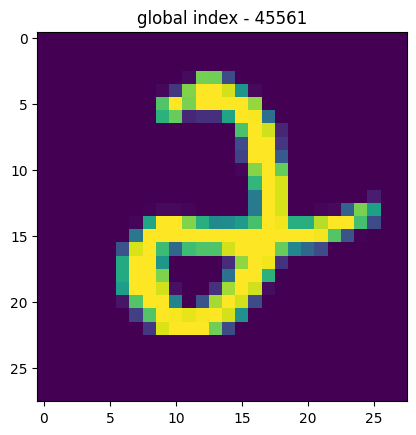

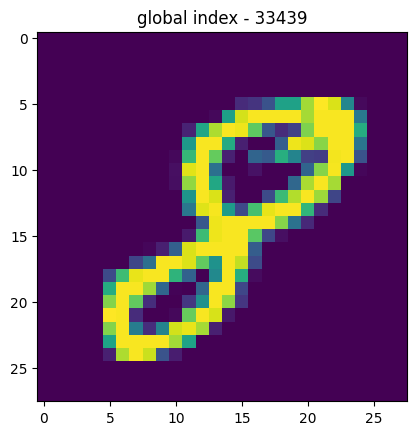

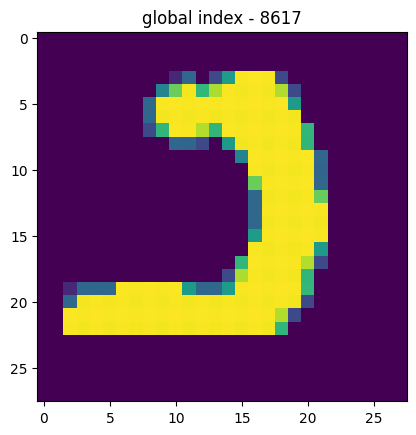

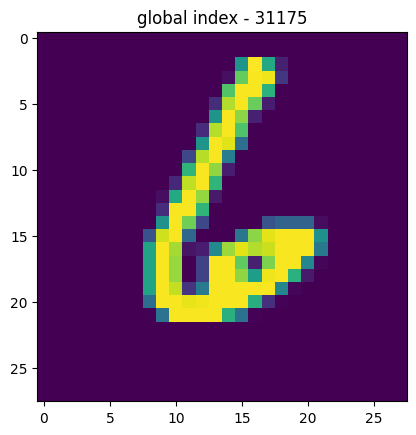

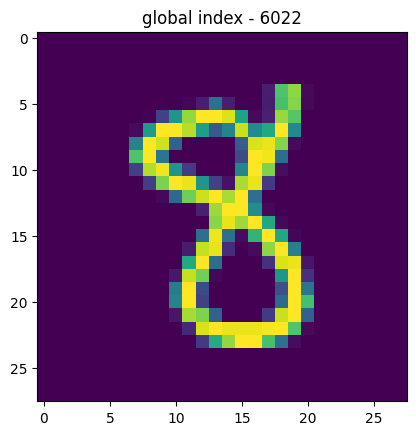

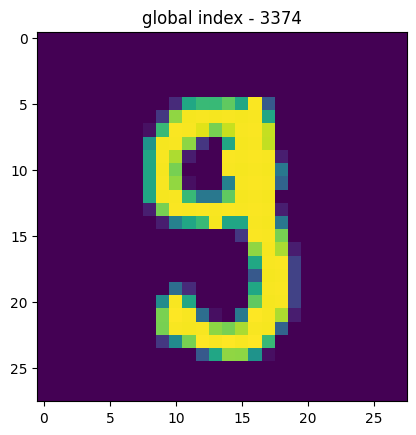

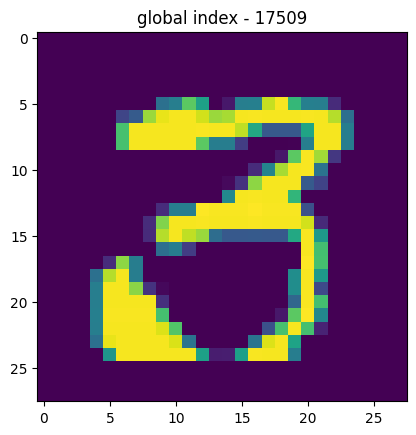

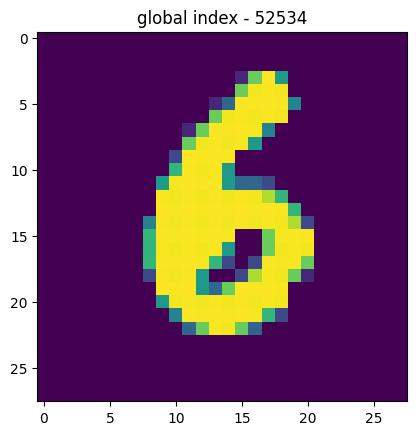

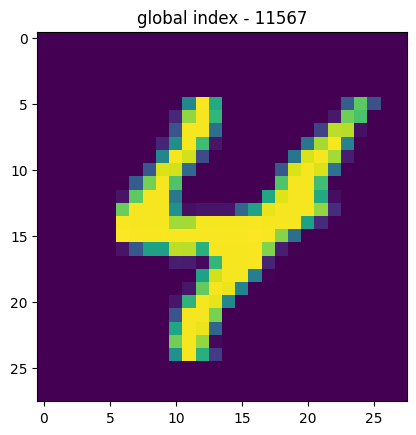

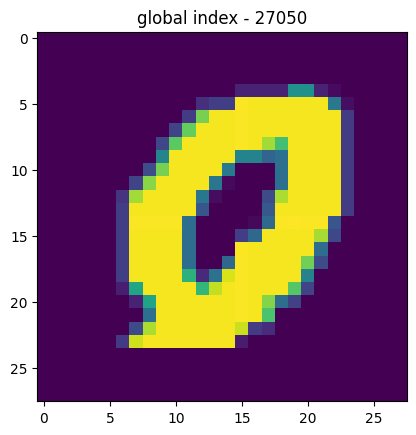

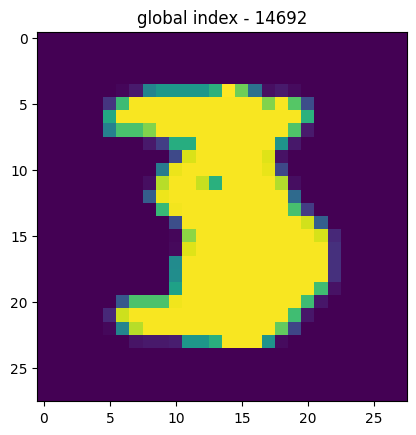

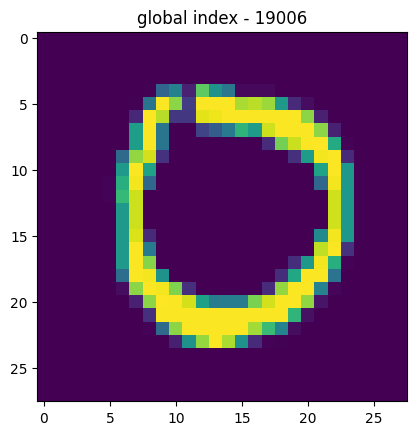

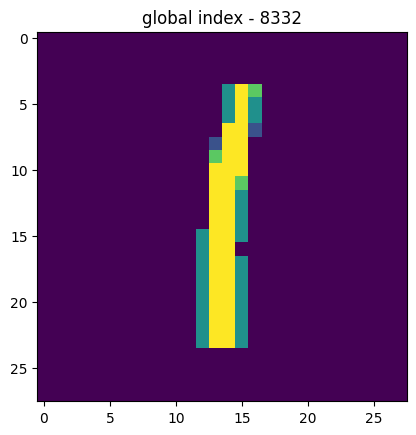

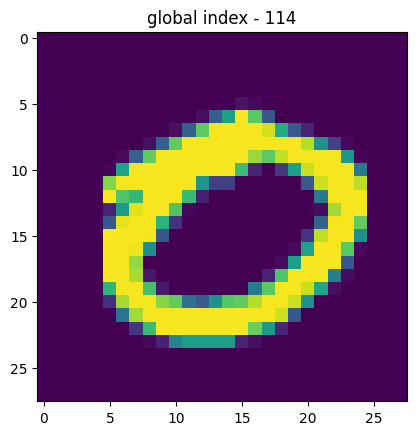

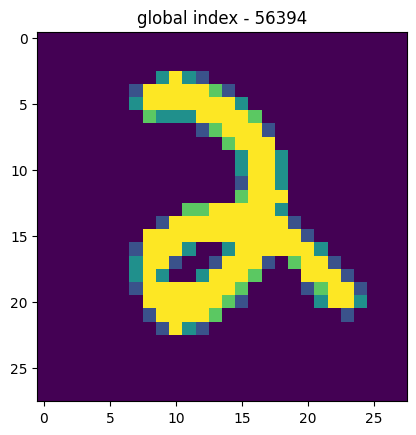

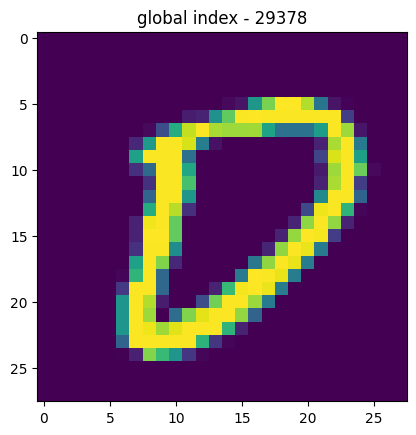

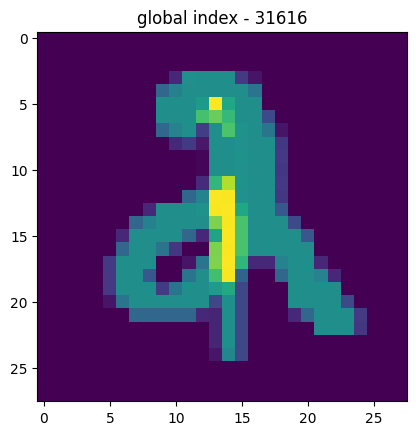

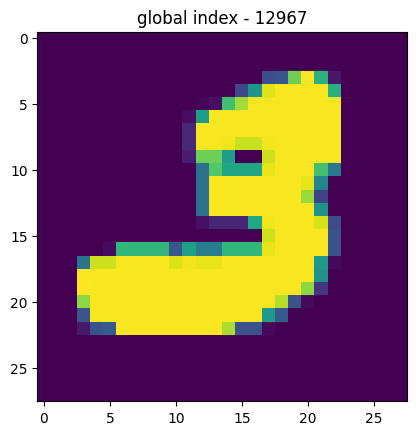

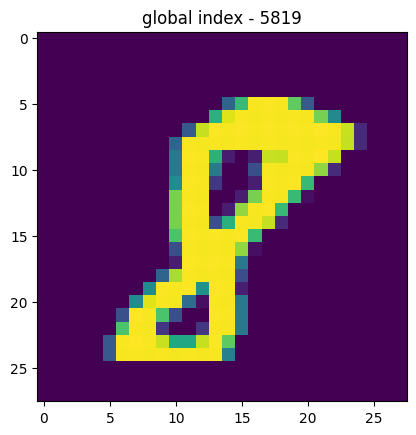

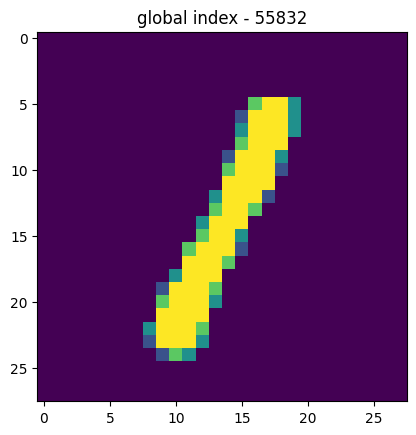

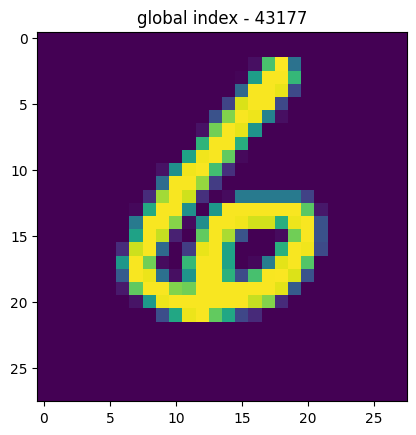

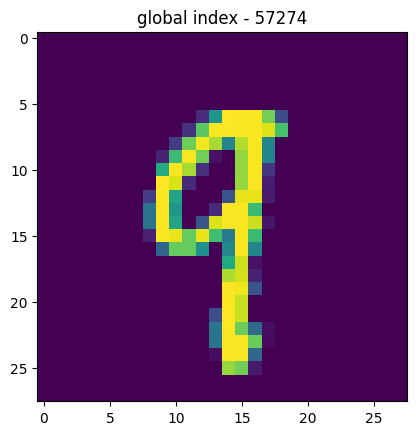

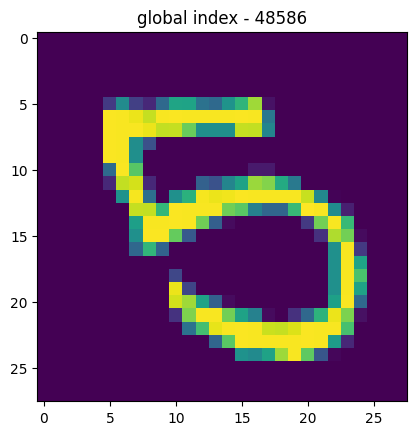

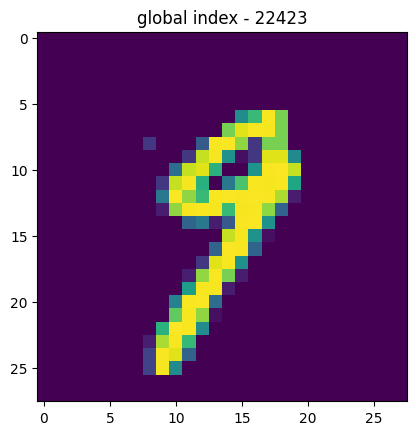

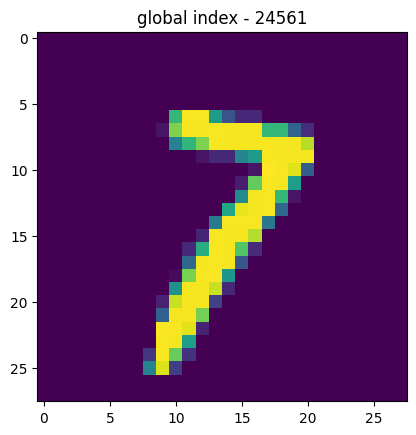

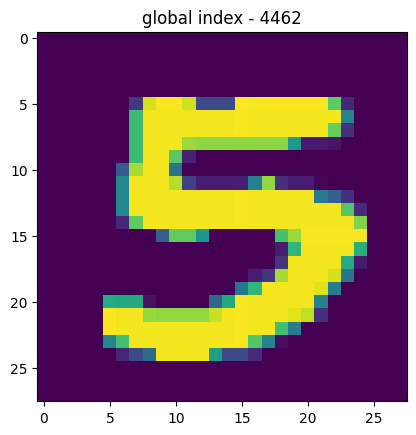

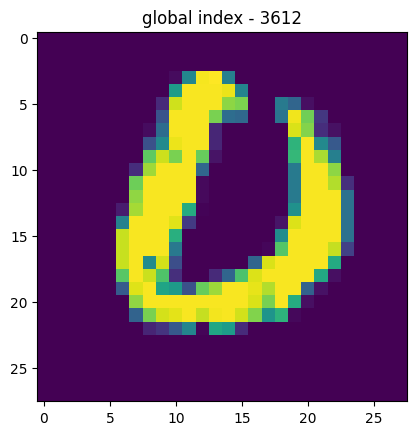

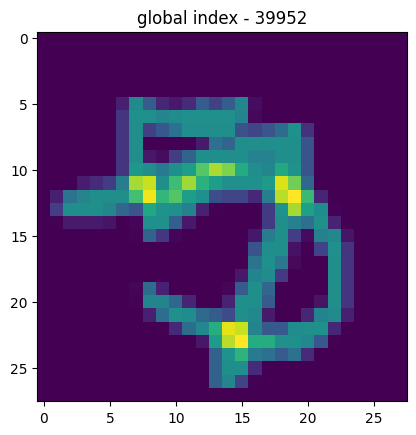

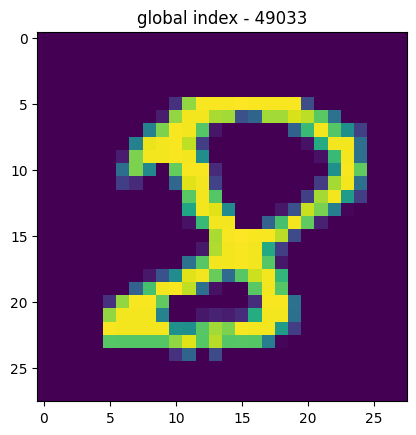

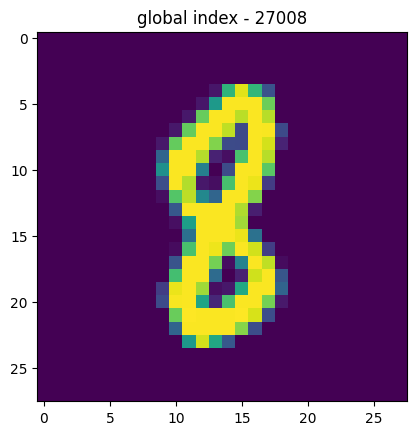

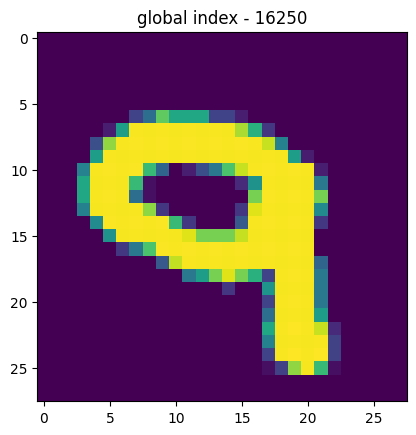

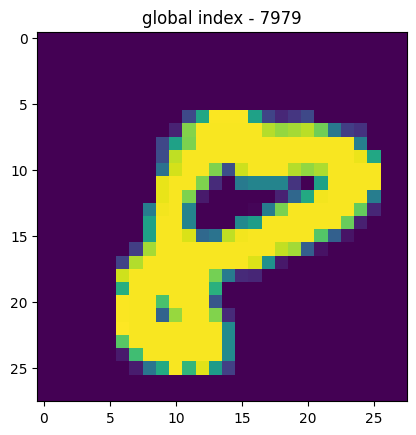

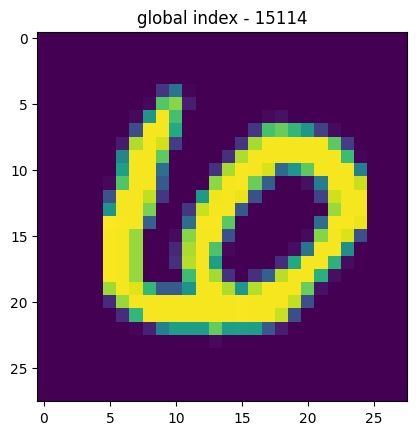

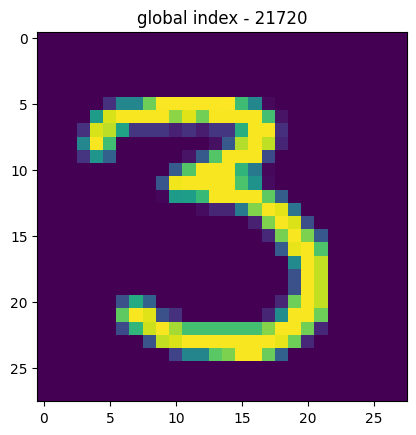

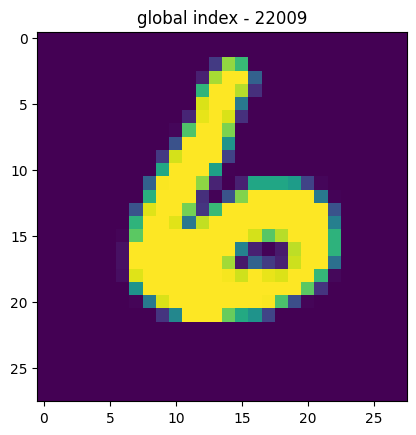

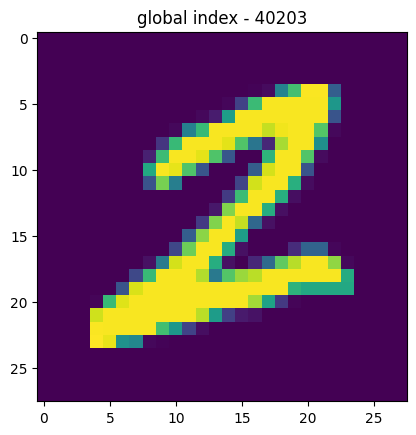

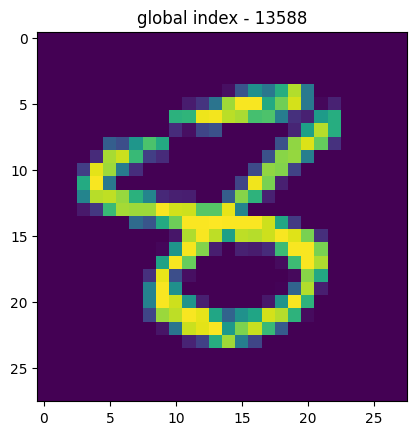

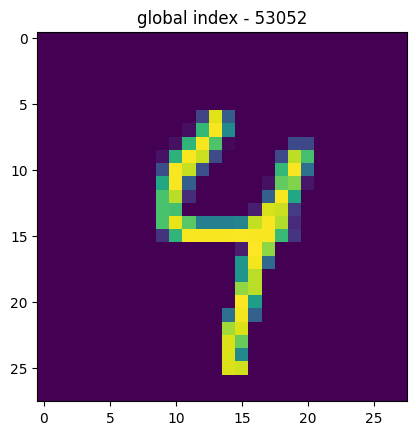

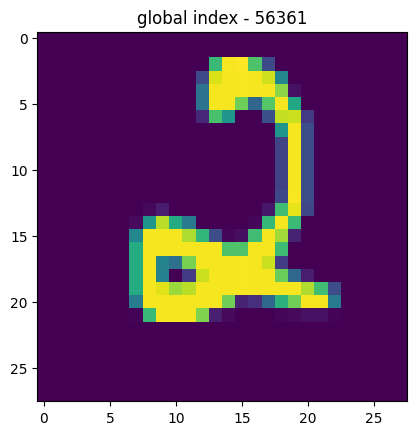

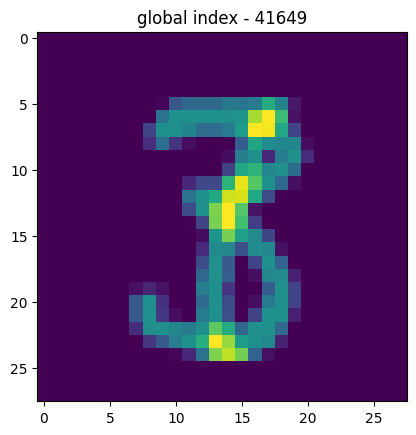

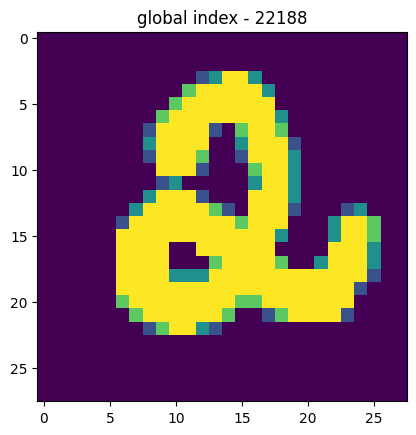

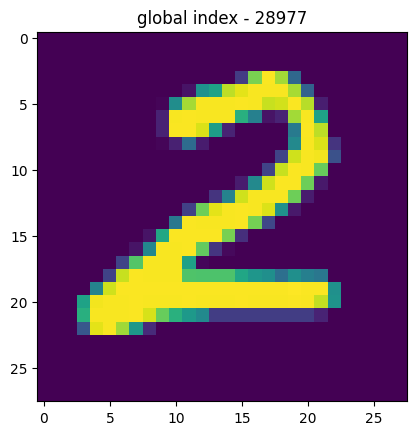

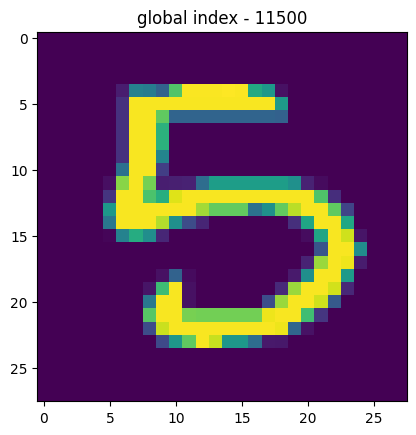

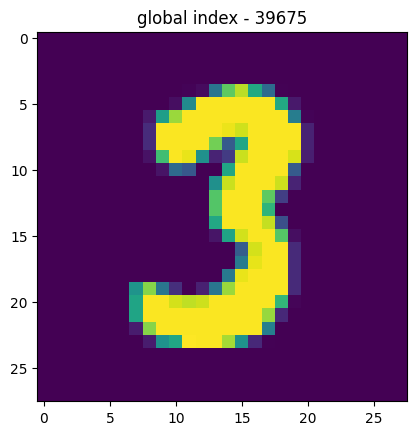

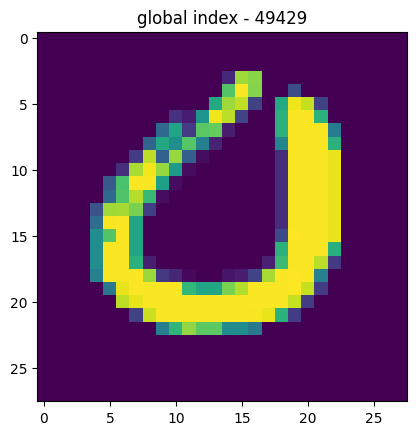

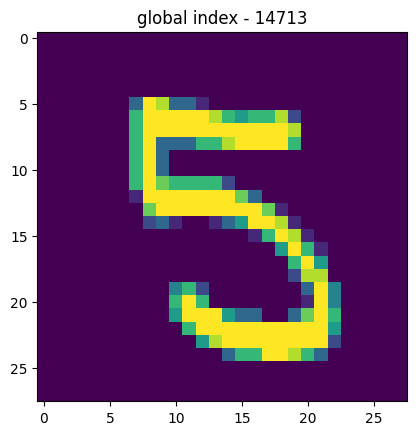

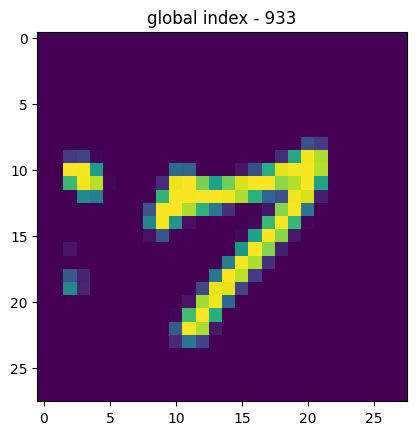

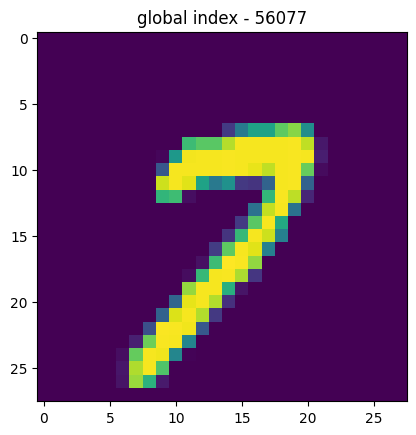

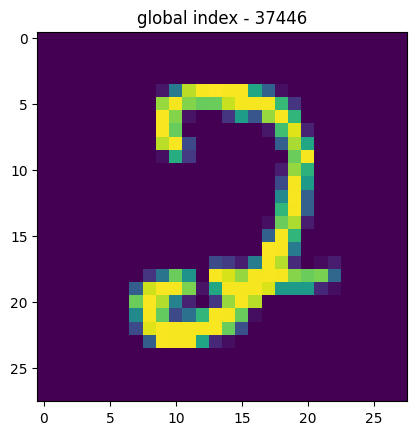

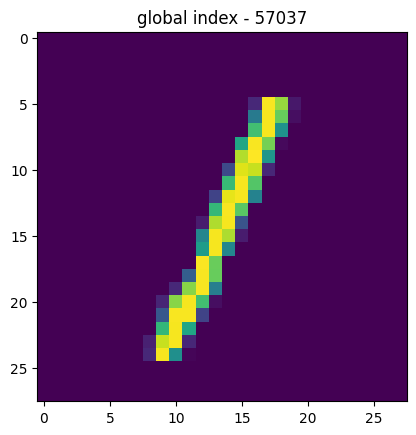

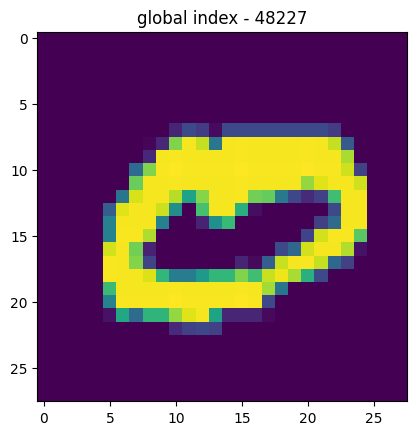

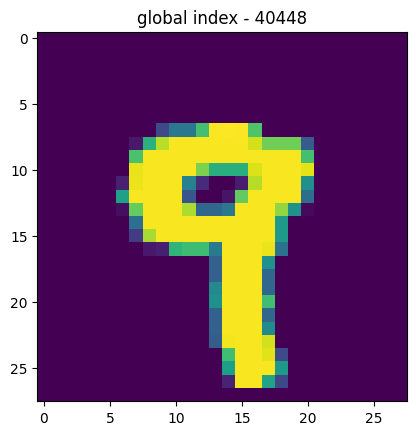

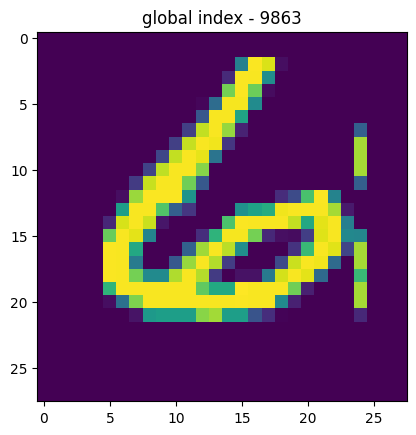

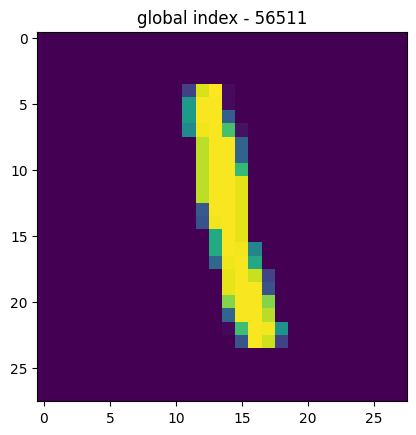

In [135]:
for idx, sl in idx_2_sum_loss.items():
  if sl > q:

    plt.imshow(train_dataset_autoencoder[idx][1].squeeze(0))
    plt.title(f"global index - {idx}")
    plt.show()

In [124]:
q_1 = np.quantile(np.array(list(sum_losses)), q=0.0005)
print(q_1)
sum(np.array(list(sum_losses)) < q_1)

9.154316586665809


30

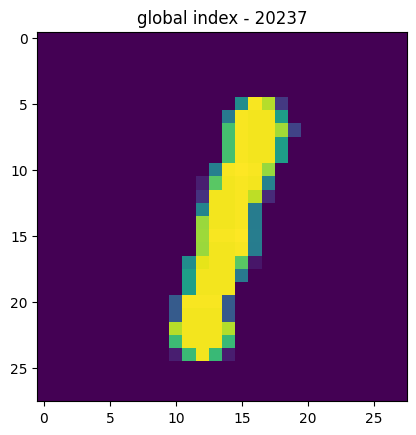

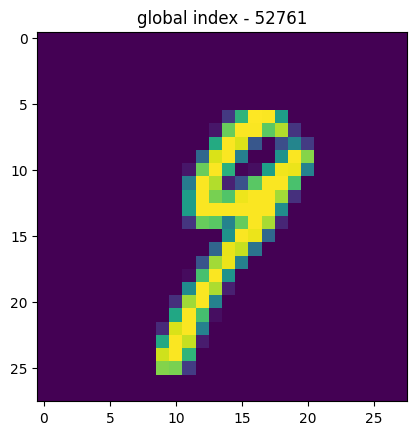

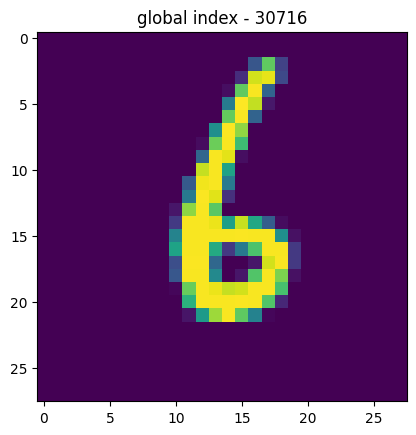

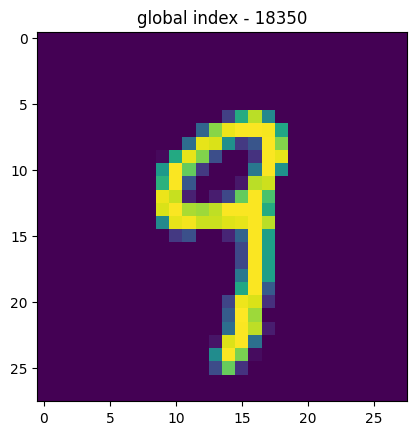

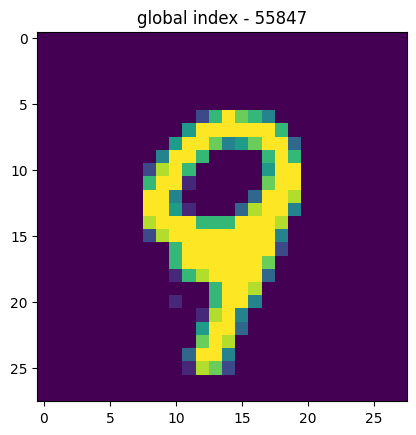

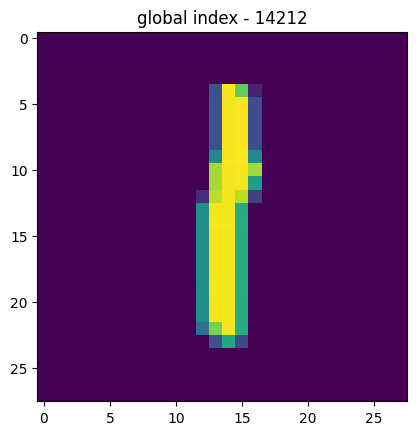

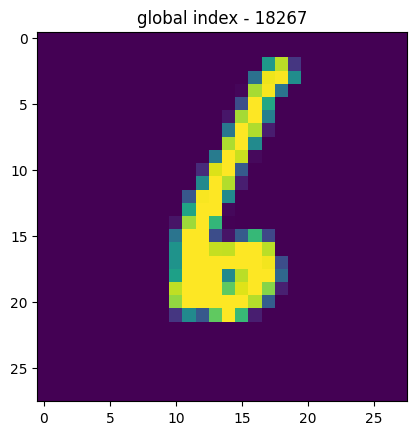

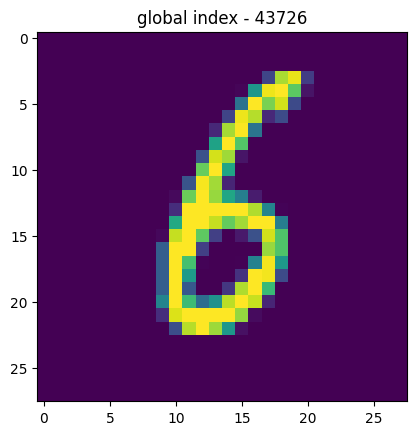

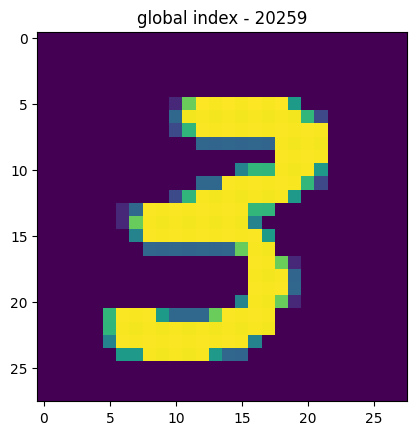

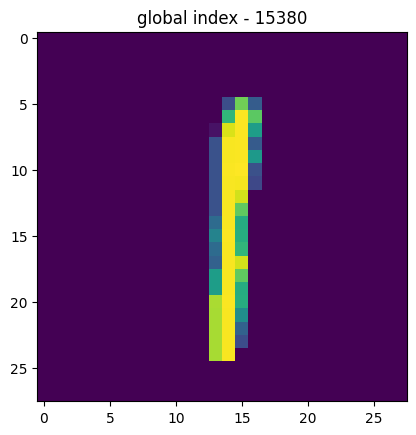

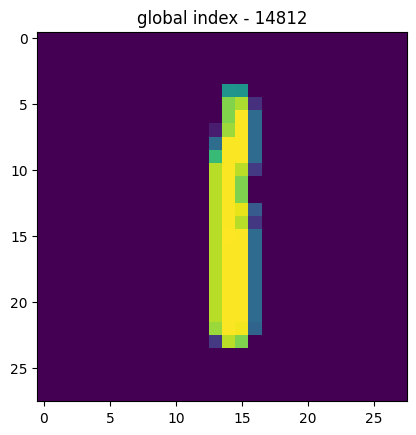

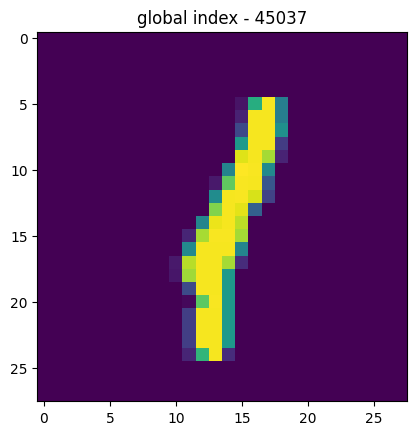

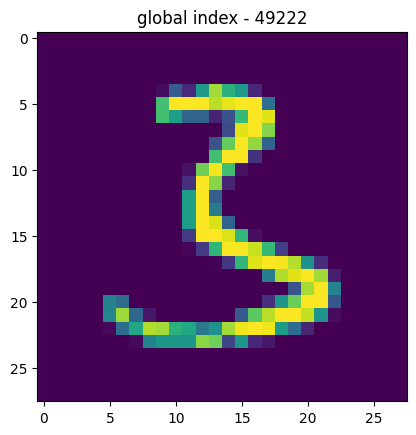

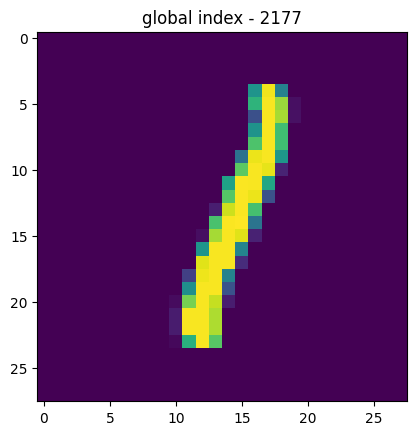

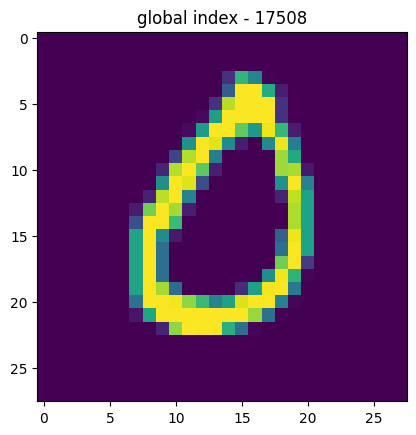

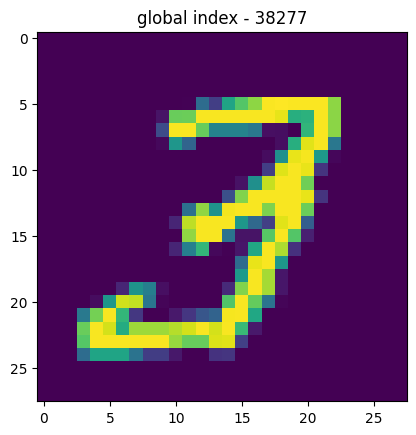

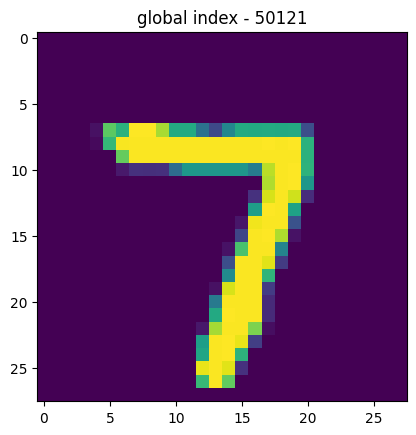

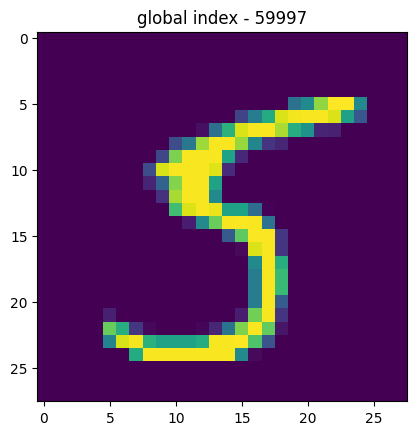

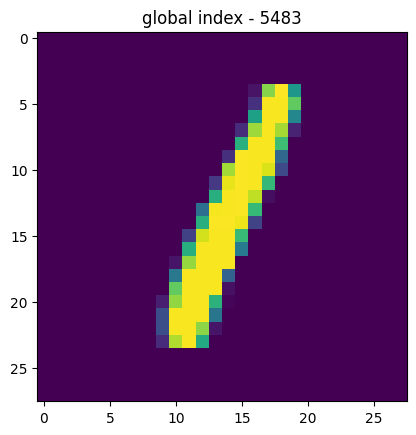

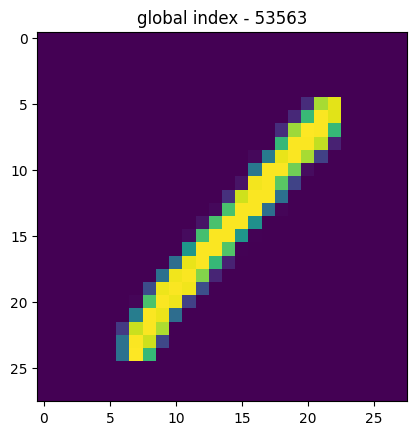

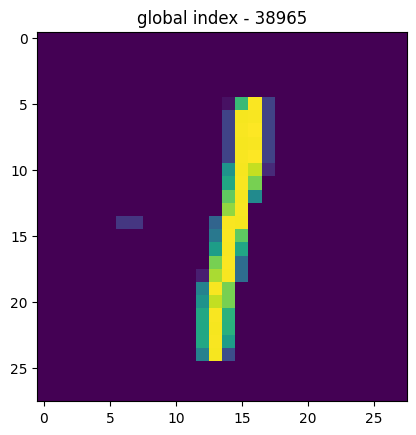

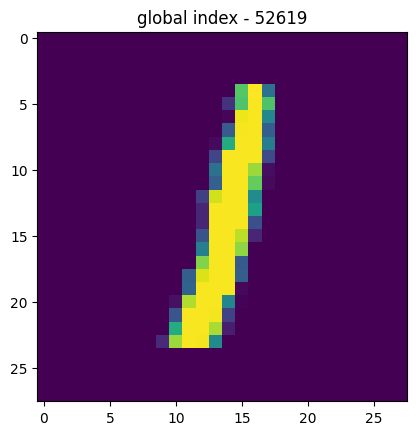

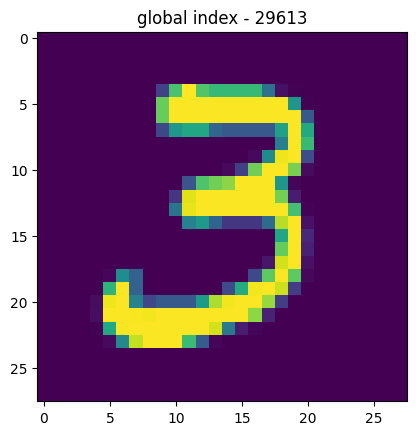

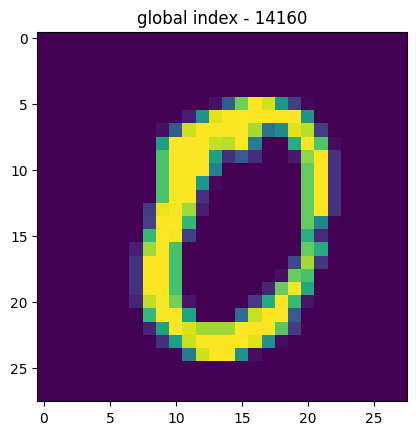

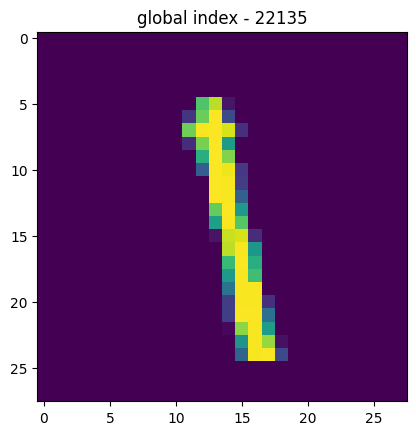

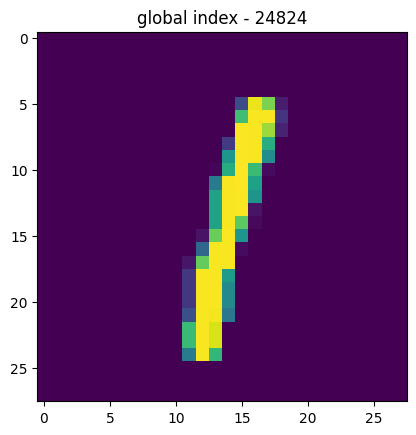

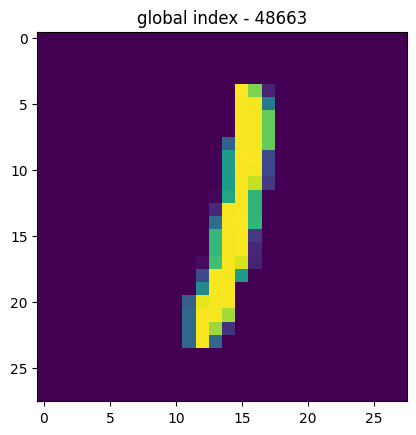

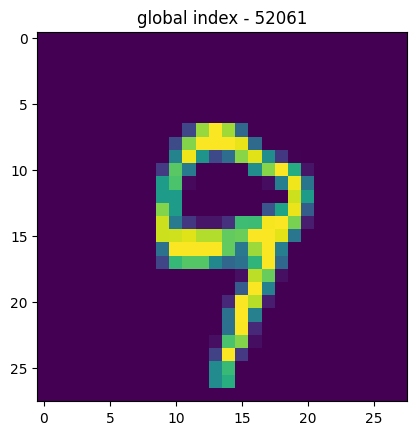

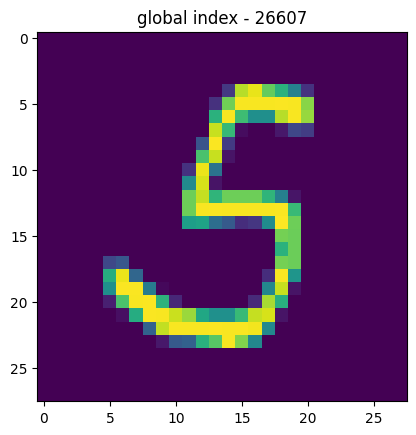

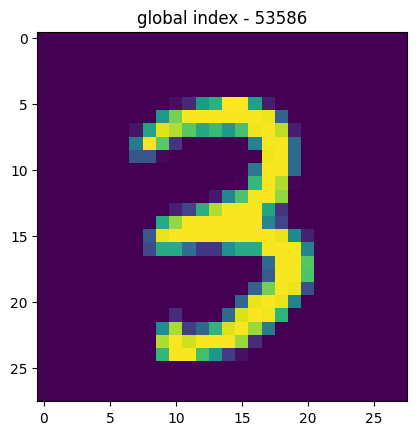

In [125]:
for idx, sl in idx_2_sum_loss.items():
  if sl < q_1:

    plt.imshow(train_dataset_autoencoder[idx][1].squeeze(0))
    plt.title(f"global index - {idx}")
    plt.show()